In [1]:
import otmol as otm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openbabel import pybel
import os
from experiment_utils import ng_experiment, p_experiment
import numpy as np
# %matplotlib widget

In [2]:
data_path = "../Data/Neon-Clusters/"
mol_pair_list_path = os.path.join(data_path, 'list')
molecule_pairs = otm.tl.parse_molecule_pairs(mol_pair_list_path, mol_type='S1')

In [3]:
otmol_res = ng_experiment(molecule_pairs, data_path, p_list=range(2,9), method = 'emd', save = True)

10-1 10-2 emd 0.32 0.05s
50-1 50-2 emd 0.47 0.03s
100-1 100-2 emd 0.21 0.10s
150-1 150-2 emd 0.19 0.23s
200-1 200-2 emd 0.51 0.65s
300-1 300-2 emd 0.12 1.08s
500-1 500-2 emd 0.11 3.01s
1000-1 1000-2 emd 0.10 12.23s


In [4]:
# much slower when # atoms is large
otmol_perturbation_res = ng_experiment(molecule_pairs, data_path, save = False, p_list = [1], n_trials = 2, perturbation=True)

10-1 10-2 emd 0.32 0.02s
50-1 50-2 emd 0.32 0.06s
100-1 100-2 emd 0.21 0.19s
150-1 150-2 emd 0.19 0.49s
200-1 200-2 emd 0.46 1.17s
300-1 300-2 emd 0.12 2.37s
500-1 500-2 emd 0.11 11.34s
1000-1 1000-2 emd 0.10 58.65s


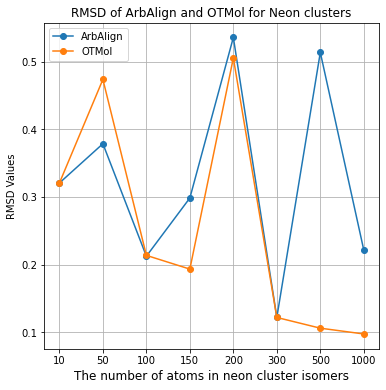

In [5]:
arbalign_res = pd.read_csv('./arbalign_output/no_reflection/NeonCluster_result.csv')
combined_df = pd.concat([arbalign_res.rename(columns={'RMSD(ArbAlign)': 'ArbAlign'}), otmol_res.rename(columns={'RMSD(OTMol)': 'OTMol'})], axis=1)
columns_to_plot = ["ArbAlign", "OTMol"]
plt.figure(figsize=(6,6))
for column in columns_to_plot:
    plt.plot(range(len(combined_df)), combined_df[column], marker='o', label=column)
plt.title("RMSD of ArbAlign and OTMol for Neon clusters")
plt.xlabel("The number of atoms in neon cluster isomers", fontsize=12)
plt.ylabel("RMSD Values")
#plt.ylim(0.5, 3)
plt.xticks(range(len(combined_df)), combined_df['# atoms'])
plt.legend()
plt.grid(True)

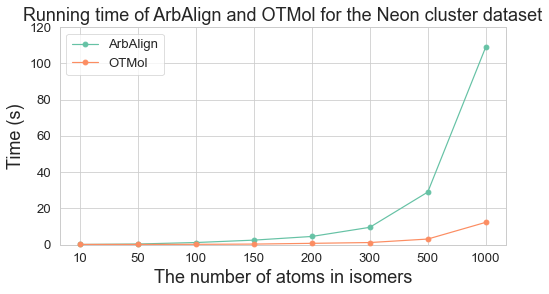

In [6]:
plt.figure(figsize=(8,4))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Set2")  
arbalign_res = pd.read_csv("./arbalign_output/no_reflection/NeonCluster_result.csv").rename(columns={'time': 'ArbAlign'})
combined_df = pd.concat([arbalign_res, otmol_res.rename(columns={'time': 'OTMol'})], axis=1)
columns_to_plot = ["ArbAlign", "OTMol"]
for column in columns_to_plot:
    plt.plot(range(len(combined_df)), combined_df[column], marker='o', label=column, clip_on=False, zorder=10)
plt.title("Running time of ArbAlign and OTMol for the Neon cluster dataset", fontsize=18)
plt.xlabel("The number of atoms in isomers", fontsize=18)
plt.ylabel("Time (s)", fontsize=18)
plt.ylim(0, 120)    
plt.xticks(range(len(combined_df)), combined_df['# atoms'])
plt.legend()
plt.grid(True)
plt.savefig("../images/ng_time.png", dpi=300, bbox_inches='tight')
plt.show()

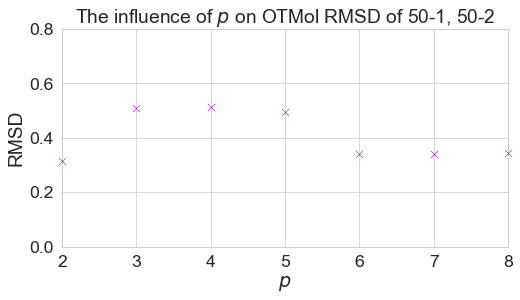

In [26]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)
sns.set_palette("Set1") 
p_list = np.arange(2,9)
p_result_50_1_50_2 = p_experiment(data_path, '50-1', '50-2', p_list=p_list)
#p_result_100_1_100_2 = p_experiment(data_path, '100-1', '100-2', p_list=p_list)
plt.figure(figsize=(8,4))
sns.scatterplot(
    data=p_result_50_1_50_2,
    x='p',
    y='RMSD(OTMol)',
    marker='x',
    s=50,
    color='m',
    #label=r'FGG$\_$55, FGG$\_$224',
    clip_on=False,
    zorder=10
)
#plt.scatter(p_result_100_1_100_2['p'], p_result_100_1_100_2['RMSD(OTMol)'], marker='x', label='100-1, 100-2', clip_on=False, zorder=10)
#plt.legend()
plt.title(r'The influence of $p$ on OTMol RMSD of 50-1, 50-2')
plt.xlim(2, 8)
plt.ylim(0, 0.8)
plt.xlabel(r'$p$')
plt.ylabel('RMSD')
plt.xticks(p_list)
plt.grid(True)
plt.savefig('../images/p_ng.png', dpi=300, bbox_inches='tight')

In [18]:
def interactive_alignment_plot_py3dmol(
    X_A: np.ndarray,
    X_B: np.ndarray,
    T_A: np.ndarray,
    T_B: np.ndarray,
    #B_A: np.ndarray,
    #B_B: np.ndarray,
    assignment: np.ndarray = None,
    nameA: str = 'A', 
    nameB: str = 'B', 
    save: bool = False
    ) -> None:
    """Plot the alignment of two structures in 3D using py3Dmol.

    Parameters
    ----------
    X_A : np.ndarray
        The coordinates of the atoms in structure A.
    X_B : np.ndarray
        The coordinates of the atoms in structure B.
    T_A : np.ndarray
        The atom labels of structure A.
    T_B : np.ndarray
        The atom labels of structure B.
    assignment: np.ndarray
        1d array. The assignment of atoms in A to atoms in B. 
        The i-th atom in A is assigned to the assignment[i]-th atom in B.
    nameA : str
        The name of structure A.
    nameB : str
        The name of structure B.
    save : bool, optional
        Whether to save the figure as an HTML file.
    """
    import py3Dmol
    
    # Create a new viewer
    viewer = py3Dmol.view(width=800, height=600)
    
    # Convert coordinates to XYZ format for structure A
    xyz_A = f"{len(X_A)}\n{nameA}\n"
    for i, (x, y, z) in enumerate(X_A):
        atom_type = T_A[i]
        xyz_A += f"{atom_type} {x:8.3f} {y:8.3f} {z:8.3f}\n"
    
    # Convert coordinates to XYZ format for structure B
    xyz_B = f"{len(X_B)}\n{nameB}\n"
    for i, (x, y, z) in enumerate(X_B):
        atom_type = T_B[i]
        xyz_B += f"{atom_type} {x:8.3f} {y:8.3f} {z:8.3f}\n"
    
    # Add structures to viewer
    viewer.addModel(xyz_A, "xyz")
    viewer.addModel(xyz_B, "xyz")
    
    # Style for structure A 
    style_A = {#"stick": {"radius": 0.0, "color": "#DC2626"},
               "sphere": {"radius": 0.15, "color": "#DC2626"}}
    
    # Style for structure B 
    style_B = {#"stick": {"radius": 0.0, "color": "#2563EB"},
               "sphere": {"radius": 0.15, "color": "#2563EB"}}
    
    # Apply styles
    viewer.setStyle({"model": 0}, style_A)
    viewer.setStyle({"model": 1}, style_B)
    
    # Add bonds for structure A
    #for i in range(len(B_A)):
    #    for j in range(i+1, len(B_A)):
    #        if B_A[i,j] == 1:
    #            viewer.addLine({"start": {"x": X_A[i,0], "y": X_A[i,1], "z": X_A[i,2]},
    #                          "end": {"x": X_A[j,0], "y": X_A[j,1], "z": X_A[j,2]},
    #                          "color": "red", "width": 0.1})
    
    # Add bonds for structure B
    #for i in range(len(B_B)):
    #    for j in range(i+1, len(B_B)):
    #        if B_B[i,j] == 1:
    #            viewer.addLine({"start": {"x": X_B[i,0], "y": X_B[i,1], "z": X_B[i,2]},
    #                          "end": {"x": X_B[j,0], "y": X_B[j,1], "z": X_B[j,2]},
    #                          "color ": "blue", "width": 2})
    
    # Add matching lines between atoms
    if assignment is None:
        assignment = np.arange(len(X_A), dtype=int)
        print("The assignment is not provided. Assuming identity assignment.")
    
    for i in range(len(X_A)):
        j = assignment[i]
        viewer.addCylinder({"start": {"x": X_A[i,0], "y": X_A[i,1], "z": X_A[i,2]},
                       "end": {"x": X_B[j,0], "y": X_B[j,1], "z": X_B[j,2]},
                       "color": "green", "radius": 0.03, "dashed": False})
    
    # Set camera and view
    viewer.zoomTo()
    viewer.setBackgroundColor('white')
    
    # Show the viewer
    viewer.show()
    if save:
        viewer.write_html(f"{nameA}_{nameB}.html")

In [ ]:
nameA = '50-1.xyz'
nameB = '50-2.xyz'
molA = next(pybel.readfile('xyz', os.path.join(data_path, nameA)))
molB = next(pybel.readfile('xyz', os.path.join(data_path, nameB)))
X_A, T_A, B_A = otm.tl.process_molecule(molA) 
X_B, T_B, B_B = otm.tl.process_molecule(molB)
assignment = otmol_res['assignment'][1]
X_B_aligned, _, _ = otm.tl.kabsch(X_A, X_B, otm.tl.permutation_to_matrix(assignment))
interactive_alignment_plot_py3dmol(X_A, X_B_aligned, T_A, T_B, assignment, '50-1', '50-2', save=False)

p influence

In [11]:
nameA = '50-1.xyz'
nameB = '50-2.xyz'
molA = next(pybel.readfile('xyz', os.path.join(data_path, nameA)))
molB = next(pybel.readfile('xyz', os.path.join(data_path, nameB)))
X_A, T_A, B_A = otm.tl.process_molecule(molA) 
X_B, T_B, B_B = otm.tl.process_molecule(molB)
i = 0
assignment = p_result_50_1_50_2['assignment'][i]
X_B_aligned, _, _ = otm.tl.kabsch(X_A, X_B, otm.tl.permutation_to_matrix(assignment))
print(p_result_50_1_50_2['p'][i], p_result_50_1_50_2['RMSD(OTMol)'][i])
interactive_alignment_plot_py3dmol(X_A, X_B_aligned, T_A, T_B, assignment, '50-1', '50-2', save=False)

2 0.3136606492958567


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [12]:
nameA = '50-1.xyz'
nameB = '50-2.xyz'
molA = next(pybel.readfile('xyz', os.path.join(data_path, nameA)))
molB = next(pybel.readfile('xyz', os.path.join(data_path, nameB)))
X_A, T_A, B_A = otm.tl.process_molecule(molA) 
X_B, T_B, B_B = otm.tl.process_molecule(molB)
i = 1
assignment = p_result_50_1_50_2['assignment'][i]
X_B_aligned, _, _ = otm.tl.kabsch(X_A, X_B, otm.tl.permutation_to_matrix(assignment))
print(p_result_50_1_50_2['p'][i], p_result_50_1_50_2['RMSD(OTMol)'][i])
interactive_alignment_plot_py3dmol(X_A, X_B_aligned, T_A, T_B, assignment, '50-1', '50-2', save=False)

3 0.5095769186670126


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

ArbAlign alignment 200

In [20]:
# sed 's/NE/Ne/g' experiment/arbalign_output/200-2-aligned_to-200-1.xyz > experiment/arbalign_output/200-2-aligned_to-200-1_Ne.xyz
molA = next(pybel.readfile("xyz", os.path.join(data_path, '200-1.xyz')))
molB = next(pybel.readfile("xyz", './arbalign_output/200-2-aligned_to-200-1_Ne.xyz'))
X_A, T_A, B_A = otm.tl.process_molecule(molA) 
X_B, T_B, B_B = otm.tl.process_molecule(molB)
X_B_aligned, _, _ = otm.tl.kabsch(X_A, X_B, np.eye(X_A.shape[0]))
print(otm.tl.root_mean_square_deviation(X_A, X_B_aligned))
interactive_alignment_plot_py3dmol(X_A, X_B_aligned, T_A, T_B, np.arange(X_A.shape[0], dtype=int), '', '', save=True)

0.5356416145624102


3Dmol.js failed to load for some reason. Please check your browser console for error messages.